# Fandom Stats and Genre Writing

#### Yvonne Gonzales
#### Course: Digital Humanities 100 Summer 2021
#### Instructor: Adam Anderson

## Introduction

Reading fanfiction feels different than reading traditionally published literature. While fanfiction might come with popular connotations of being romantic or sexual in nature, fanfiction is more of a mode of writing than it is one specific genre. Using The user generated tagging systems and topic modelling, I want to figure out what makes fanfiction what it is. What topics are most popular, and how do people categorize them? In a future project, I intend to do a similar analysis of popular published literature, but this serves as a starting point for comparing fanfiction to standardized literary forms. Fanfiction has often been studied as a cultural, psychological object, but lacks research as a form of literature, and I want to investigate why it is or why it might not be.

Most of the code here was written referencing [the notebooks in this GitHub repo from the Berkeley D-Lab, written by Evan Muzzall and edited by Brooks Jessup](https://github.com/dlab-berkeley/DIGHUM101-2021).

## Research Questions

1. Primary Research Question. How is fanfiction tagged, and what does this categorization say about fanfiction as a whole?

    a. Are there any specific names or relationships that show up disproportionately?
    
    b. What are the percentages of M/M stories, F/F stories, F/M stories, and other gender combinations? What might that say about the genre? 
    
    c. How popular is fanfiction? How popular are specific fandoms? Does the amount of clicks line up with the amount of likes?

## Dataset

Using [a webscraper by UC Berkeley graduate student Sarah Sterman and Stanford student Jingyi Li](https://github.com/radiolarian/AO3Scraper), I collected the data and full text from the top 3.5k works (aka "fics"), as sorted by likes (or as Ao3 calls them, kudos) of fanfiction on the popular fanfiction website [Archive of Our Own](https://archiveofourown.org/).

# Importing Data and Libraries

In [108]:
from collections import Counter # Count most common words
import gensim # word2vec model
import matplotlib.pyplot as plt
%matplotlib inline
import nltk # natural language toolkit
from nltk.corpus import stopwords
import numpy as np 
import os
import pandas as pd

import seaborn as sns

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

In [109]:
from gensim.parsing.preprocessing import remove_stopwords

In [110]:
os.chdir("../AO3Scraper")
%pwd

'/Users/yvonnegonzales/Desktop/DH100/AO3Scraper'

In [111]:
plt.style.use('default')

## Core Data Set - Sorted by Kudos, Top 3500

Pulled on June 3, 2021

In [112]:
top_fics = pd.read_csv("fanfics.csv")
top_fics.head()

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
0,2080878,I Am Groot,['sherlocksmyth'],Explicit,NaN,"Guardians of the Galaxy - All Media Types, Mar...",NaN,Groot (Marvel),NSFW,English,...,2014-08-04,1308,1/1,2931,98099,3842,848754,"['sddhdeheifis', 'XxSilentiumxX', 'Mai_3', 'Am...",[],I am Groot. I am Groot. I am Groot. I am Groot...
1,8337607,Yesterday Upon The Stair,['PitViperOfDoom'],Teen And Up Audiences,Gen,Pu nohiroakademia | Boku no Hero Academia | My...,"Midoriya Izuku & Yagi Toshinori | All Might, M...","Midoriya Izuku, Yagi Toshinori | All Might, Mi...","Alternate Universe - Canon Divergence, BAMF Mi...",English,...,2019-10-12,424070,60/60,19940,62276,14836,1765887,"['DaneyC', 'fucksimoncowell', 'TheBrotatoPatch...",[],"""Excuse me? Um, excuse me?""\n\nIt takes a whil..."
2,5096105,In Another Life,['LittleLuxray'],Teen And Up Audiences,M/M,Haikyuu!!,Akaashi Keiji/Bokuto Koutarou,"Akaashi Keiji, Bokuto Koutarou, Kozume Kenma, ...","Angst, Fluff and Angst, Alternate Universe - H...",English,...,2015-10-28,22995,1/1,5103,56228,9911,1966460,"['534316819191919estoyTouched_starved', 'voidn...",[],\n\n \n\nIt had been some time since Akaashi ...
3,10057010,All the Young Dudes,['MsKingBean89'],Mature,M/M,Harry Potter - J. K. Rowling,"Sirius Black/Remus Lupin, Sirius Black & Remus...","Remus Lupin, Sirius Black, James Potter, Lily ...","Marauders' Era, Marauders, Marauders Friendshi...",English,...,2018-11-12,526969,188/188,16214,48865,10704,2683521,"['liceeggs', 'JuliaTheStarsCollideDarling', 's...",[],"Saturday 7th August, 1971\n\nHe woke up in the..."
4,5457191,a reylo fic,['treezie'],General Audiences,F/M,"Star Wars - All Media Types, Star Wars Episode...",Kylo Ren/Rey (Star Wars),"Kylo Ren, Rey (Star Wars)","stan loona, #ReleaseTheRianJohnsonCut",English,...,2015-12-19,12,1/1,8093,47051,1814,304252,"['windowpane_rain', 'Giraffejuice', 'ew7756', ...",[],rey picks up kylo and dunks him into the garba...


# Comparison Data Sets

I scraped much smaller data sets as comparison points. Archive of Our Own's default sorting is by "Most Recently Updated," so to get a more generally representative dataset, popularity irrelevant, I scraped the most recent 500 fics of individual fandoms. I picked large fandoms that I have some tangential knowledge of that are based on different forms of media: Anime, RPF (real person fic, think: celebrities), Movies, and Books. I also grabbed the data for the most recent 500, fandom and popularity irrelevant, as a sort of control.

These are rather small datasets, in comparison with the amount of works in fandoms as a whole, but serve as a proof of concept until I can access larger data sets.

### Recent - All Fandoms, Most Recent 500

Pulled on June 23, 2021

In [113]:
recent_fics = pd.read_csv("recent_fics.csv")
recent_fics.head(1)

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
0,32137747,my mind always reminds me (ur a nice idea),['kentaurus'],General Audiences,M/M,The Boyz (Korea Band),"Lee Jaehyun | Hyunjae/Lee Juyeon, juyeon - Rel...","Lee Jaehyun | Hyunjae, Lee Juyeon (The Boyz), ...","jumil - Freeform, bbangmil bestfriends fo life...",English,...,2021-06-23,3426,1/1,NaN,NaN,NaN,0,[],[],"it was afternoon, class starting in five minut..."


### Anime Sample - My Hero Academia, Most Recent 500

Pulled on June 23, 2021

In [114]:
bnha_fics = pd.read_csv("bnha_fics.csv")
bnha_fics.head(1)

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
0,32138932,Summer's Over Now (but the School Year has Jus...,['GraceFallsConfidential'],Teen And Up Audiences,"M/M, Multi",Pu nohiroakademia | Boku no Hero Academia | My...,"Bakugou Katsuki/Kirishima Eijirou, Ashido Mina...","Kirishima Eijirou, Bakugou Katsuki, Kaminari D...","Trans Kirishima Eijirou, Genderfluid Character...",English,...,2021-06-23,743,1/?,NaN,1.0,NaN,0,['lovefierro'],[],"Summer is my favorite season.\n\nWell, not by ..."


In [115]:
bnha_fics.shape

(491, 22)

### RPF Sample - BTS (K-pop Band), Most Recent 500

Pulled on June 23, 2021

In [116]:
bts_fics = pd.read_csv("bts_fics.csv")
bts_fics.head(1)

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
0,29599878,Like an Echo,['yoongishooketh'],Mature,F/M,bangtansonyeondan | Bangtan Boys | BTS,NaN,"Kim Taehyung | V, Kim Seokjin | Jin, Kim Namjo...","Alternate Universe - Soulmates, Soulmates, Rin...",English,...,2021-06-23,32954,31/?,NaN,4.0,2.0,270,"['NouraBenLahcen', 'Dev_96', 'daedreaminyoonie...",[],Hello again!Welcome to book two of my BTS soul...


### Movie Sample - Marvel Cinematic Universe, Most Recent 500

Pulled on June 23, 2021

In [117]:
mcu_fics = pd.read_csv("mcu_fics.csv")
mcu_fics.head(1)

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
0,32140645,Cafune,['Anarchyduck'],General Audiences,F/M,"Spider-Man (Tom Holland Movies), Marvel Cinema...",Michelle Jones/Peter Parker,"Michelle Jones, Peter Parker","Fluff, Fluff without Plot, Established Relatio...",English,...,2021-06-23,455,1/1,NaN,1.0,NaN,1,[],[],\nPeter balances on the thin line between cons...


### Book Sample - Harry Potter, Most Recent 500

Pulled on June 23, 2021

In [118]:
hp_fics = pd.read_csv("hp_fics.csv")
hp_fics.head(1)

,work_id,title,author,rating,category,fandom,relationship,character,additional tags,language,...,status date,words,chapters,comments,kudos,bookmarks,hits,all_kudos,all_bookmarks,body
0,25986979,Star Crossed Through Time,['SlytherinLovesAGryffindor'],Explicit,F/M,Harry Potter - J. K. Rowling,Hermione Granger/Severus Snape,"Hermione Granger, Severus Snape, Harry Potter,...","Romance, POV Hermione Granger, POV Severus Sna...",English,...,2021-06-24,411678,87/200,2324.0,1304.0,246.0,70799,"['LeaLea7', 'billie11598', 'Stille_und_regen',...",[],A quick few words before we dive into the stor...


# Frequency Distributions

For the purpose of searching and categorizing tags, let's start by copying into new dataframes to preserve the original data and dropping all rows with empty cells so it doesn't break our code.

Let's go row by row for the first, and largest data set.

In [119]:
dropped_na = top_fics.copy()

In [120]:
dropped_na = dropped_na.dropna(subset=["additional tags"])

In [121]:
dropped_na.shape

(3467, 22)

It worked! Let's do it again for all of my comparison datasets, too.

In [122]:
recent_dropped = recent_fics.copy()
recent_dropped = recent_dropped.dropna(subset=["additional tags"])
recent_dropped.shape

(441, 22)

In [123]:
bnha_dropped = bnha_fics.copy()
bnha_dropped = bnha_dropped.dropna(subset=["additional tags"])
bnha_dropped.shape

(476, 22)

In [124]:
bts_dropped = bts_fics.copy()
bts_dropped = bts_dropped.dropna(subset=["additional tags"])
bts_dropped.shape

(451, 22)

In [125]:
mcu_dropped = mcu_fics.copy()
mcu_dropped = mcu_dropped.dropna(subset=["additional tags"])
mcu_dropped.shape

(458, 22)

In [126]:
hp_dropped = hp_fics.copy()
hp_dropped = hp_dropped.dropna(subset=["additional tags"])
hp_dropped.shape

(427, 22)

As you can see by the number of columns in each dataset, I have very different amounts of data in each dataset. I will normalize them by using frequency percentages, and not just frequency counts.

## Rating Distribution

Ratings on Archive of Our Own are similar to movie ratings, in that they are used to show how "appropriate" a work is. "Explicit" is for either explicitly sexual or perhaps highly violent, "Mature" is for perhaps impilcations of sexual content, language, or anything else that makes it above "Teen and Up Audiences." "General Audiences" contain nothing that require a warning, and "Not Rated" could be anything.

Remember, these are all tagged by the creators, so there may be wide variance in these definitions and the content of these works.

### Setting up the Rating Dataframes

Let's start by setting up our percentage dataframe for popular fics.

In [127]:
rating_dist = pd.DataFrame(dropped_na["rating"].value_counts(normalize=True))*100

In [128]:
rating_dist = rating_dist.reset_index()
rating_dist

,index,rating
0,Teen And Up Audiences,35.708105
1,Explicit,31.727718
2,Mature,18.603980
3,General Audiences,9.576002
4,Not Rated,4.384194


In [129]:
rating_dist = rating_dist.rename(columns={"index":"Rating","rating":"%Frequency"})

In [130]:
rating_dist

,Rating,%Frequency
0,Teen And Up Audiences,35.708105
1,Explicit,31.727718
2,Mature,18.603980
3,General Audiences,9.576002
4,Not Rated,4.384194


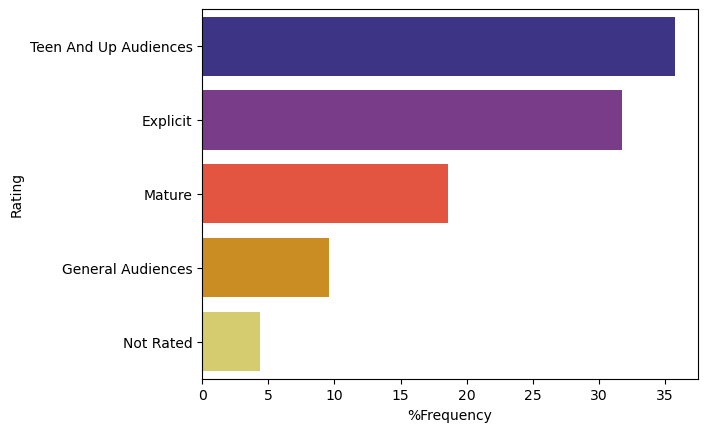

In [131]:
rating_fig = sns.barplot(x = '%Frequency', 
                         y = 'Rating', 
                         data = rating_dist,
                         orient="h",
                         palette="CMRmap")

Awesome, it worked! Here we can see that "Teen and Up" is the most popular rating in our corpus of popular works, but "Explicit" follows closely behind.

Now let's see how that compares to our other fandoms and datasets! I'm just doing the same thing to this data that I did above.

In [132]:
# Adding a tag to that ^ dataset to differentiate it
rating_dist["Set"] = "Popular"
rating_dist

,Rating,%Frequency,Set
0,Teen And Up Audiences,35.708105,Popular
1,Explicit,31.727718,Popular
2,Mature,18.603980,Popular
3,General Audiences,9.576002,Popular
4,Not Rated,4.384194,Popular


In [133]:
# Just doing everything we did above to all data sets!

recent_dist = pd.DataFrame(recent_dropped["rating"].value_counts(normalize=True))*100
bnha_dist = pd.DataFrame(bnha_dropped["rating"].value_counts(normalize=True))*100
bts_dist = pd.DataFrame(bts_dropped["rating"].value_counts(normalize=True))*100
mcu_dist = pd.DataFrame(mcu_dropped["rating"].value_counts(normalize=True))*100
hp_dist = pd.DataFrame(hp_dropped["rating"].value_counts(normalize=True))*100

recent_dist = recent_dist.reset_index()
bnha_dist = bnha_dist.reset_index()
bts_dist = bts_dist.reset_index()
mcu_dist = mcu_dist.reset_index()
hp_dist = hp_dist.reset_index()

In [134]:
recent_dist = recent_dist.rename(columns={"index":"Rating","rating":"%Frequency"})
bnha_dist = bnha_dist.rename(columns={"index":"Rating","rating":"%Frequency"})
bts_dist = bts_dist.rename(columns={"index":"Rating","rating":"%Frequency"})
mcu_dist = mcu_dist.rename(columns={"index":"Rating","rating":"%Frequency"})
hp_dist = hp_dist.rename(columns={"index":"Rating","rating":"%Frequency"})

In [135]:
recent_dist["Set"] = "Recent"
bnha_dist["Set"] = "Anime/BNHA"
bts_dist["Set"] = "RPF/BTS"
mcu_dist["Set"] = "Movie/MCU"
hp_dist["Set"] = "Book/HP"

In [136]:
multi_rating_dist = pd.concat([rating_dist, recent_dist, bnha_dist, bts_dist, mcu_dist, hp_dist])
multi_rating_dist

,Rating,%Frequency,Set
0,Teen And Up Audiences,35.708105,Popular
1,Explicit,31.727718,Popular
2,Mature,18.603980,Popular
3,General Audiences,9.576002,Popular
4,Not Rated,4.384194,Popular
0,Teen And Up Audiences,32.426304,Recent
1,Mature,22.902494,Recent
2,Explicit,17.913832,Recent
3,General Audiences,16.099773,Recent
4,Not Rated,10.657596,Recent


Okay, all of our data is set up and in one dataframe. Let's see how it looks!

### Ratings Comparison

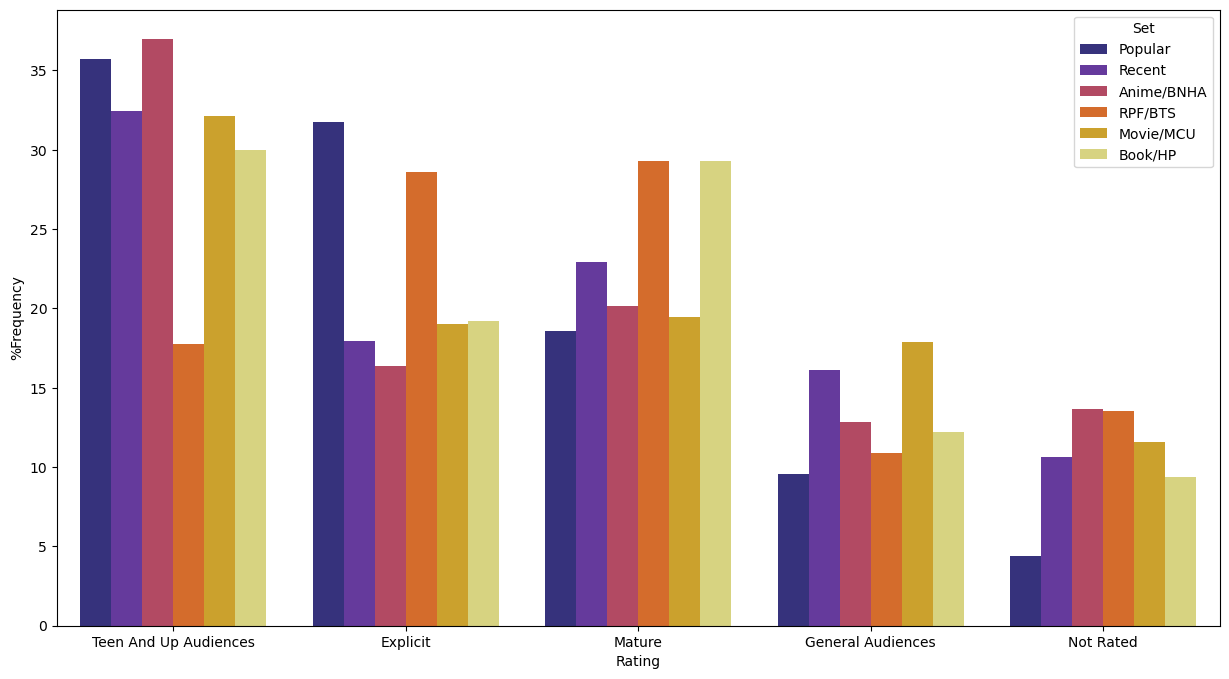

In [137]:
plt.figure(figsize=(15,8))
multi_rating_fig = sns.barplot(x = 'Rating', 
                               y = '%Frequency',
                               hue = 'Set',
                               data = multi_rating_dist,
                               orient="v",
                              palette="CMRmap")

The immediate outliers here are in the explicit tag. It looks like, outside of the BTS fandom, explicit works are more popular with readers than they are for writers. Popular fics are also very rarely not rated, where it's not all that uncommon for unrated works to be written and posted. Heads up, writers: if you want your work to be read, make sure to rate it, and Explicit-tagged works are reader's favorite.

## Tag Distribution

Tags are the user-generated subgenre markers on works in Archive of Our Own.

Here we're going to do something similar to what we did with ratings, but with tags. The tags get more complicated, since they are all in one column, where multiple are listed in one long string. Luckily, they're separated by commas, but I still have a lot more cleaning to do.

In [138]:
tag_string = ','.join(dropped_na["additional tags"].values)
tag_tokens = tag_string.split(",")
tag_tokens = list(map(str.strip, tag_tokens))
freq_tags = Counter(tag_tokens)
tags_dist = pd.DataFrame(freq_tags.most_common(25), columns = ["Tag", "Frequency"])
tags_dist

,Tag,Frequency
0,Fluff,674
1,Angst,468
2,Hurt/Comfort,412
3,Alternate Universe - Canon Divergence,380
4,Slow Burn,364
5,Humor,325
6,Alternate Universe,275
7,Pining,225
8,Romance,219
9,First Time,216


Data cleaning for the set of popular works done! Let's see how it looks

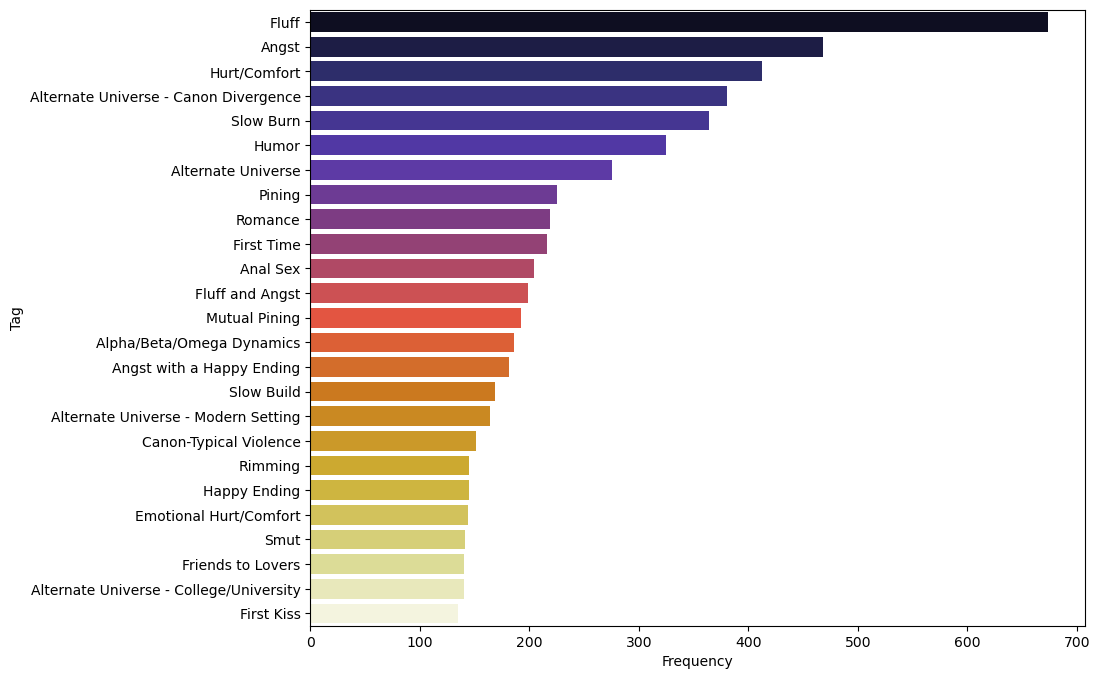

In [139]:
plt.figure(figsize=(10,8))
tags_fig = sns.barplot(x = 'Frequency', 
                         y = 'Tag', 
                         data = tags_dist,
                         orient="h",
                         palette="CMRmap")

That looks awesome! We can see how popular emotion based tagging is in fanfiction. People are searching more emotional genre markers more than they are for theme/setting markers.

Now, you know the drill, I'm going to start processing the rest of the datasets in the exact same way.

In [140]:
# making sure that I'm searching my other fandoms for these specific tags for comparison; all fandoms are going to have unique top tags which won't help here

top_tags = list(tags_dist["Tag"])

In [141]:
tags_dist["Percent"] = (tags_dist["Frequency"] / tags_dist["Frequency"].sum()) * 100

In [142]:
# recent tag frequency dataframe
tag_string = ','.join(recent_dropped["additional tags"].values)
tag_tokens = tag_string.split(",")
tag_tokens = list(map(str.strip, tag_tokens))
new_tokens = [tag for tag in tag_tokens if tag in top_tags]
freq_tags = Counter(new_tokens)
recent_tag_dist = pd.DataFrame(freq_tags.most_common(25), columns = ["Tag", "Frequency"])
recent_tag_dist["Percent"] = (recent_tag_dist["Frequency"] / recent_tag_dist["Frequency"].sum()) * 100
recent_tag_dist["Set"] = "Recent"

# BNHA tag frequency dataframe
tag_string = ','.join(bnha_dropped["additional tags"].values)
tag_tokens = tag_string.split(",")
tag_tokens = list(map(str.strip, tag_tokens))
new_tokens = [tag for tag in tag_tokens if tag in top_tags]
freq_tags = Counter(new_tokens)
bnha_tag_dist = pd.DataFrame(freq_tags.most_common(25), columns = ["Tag", "Frequency"])
bnha_tag_dist["Percent"] = (bnha_tag_dist["Frequency"] / bnha_tag_dist["Frequency"].sum()) * 100
bnha_tag_dist["Set"] = "Anime/BNHA"

# BTS tag frequency dataframe
tag_string = ','.join(bts_dropped["additional tags"].values)
tag_tokens = tag_string.split(",")
tag_tokens = list(map(str.strip, tag_tokens))
new_tokens = [tag for tag in tag_tokens if tag in top_tags]
freq_tags = Counter(new_tokens)
bts_tag_dist = pd.DataFrame(freq_tags.most_common(25), columns = ["Tag", "Frequency"])
bts_tag_dist["Percent"] = (bts_tag_dist["Frequency"] / bts_tag_dist["Frequency"].sum()) * 100
bts_tag_dist["Set"] = "RPF/BTS"

# MCU tag frequency dataframe
tag_string = ','.join(mcu_dropped["additional tags"].values)
tag_tokens = tag_string.split(",")
tag_tokens = list(map(str.strip, tag_tokens))
new_tokens = [tag for tag in tag_tokens if tag in top_tags]
freq_tags = Counter(new_tokens)
mcu_tag_dist = pd.DataFrame(freq_tags.most_common(25), columns = ["Tag", "Frequency"])
mcu_tag_dist["Percent"] = (mcu_tag_dist["Frequency"] / mcu_tag_dist["Frequency"].sum()) * 100
mcu_tag_dist["Set"] = "Movie/MCU"

# HP tag frequency dataframe
tag_string = ','.join(hp_dropped["additional tags"].values)
tag_tokens = tag_string.split(",")
tag_tokens = list(map(str.strip, tag_tokens))
new_tokens = [tag for tag in tag_tokens if tag in top_tags]
freq_tags = Counter(new_tokens)
hp_tag_dist = pd.DataFrame(freq_tags.most_common(25), columns = ["Tag", "Frequency"])
hp_tag_dist["Percent"] = (hp_tag_dist["Frequency"] / hp_tag_dist["Frequency"].sum()) * 100
hp_tag_dist["Set"] = "Book/HP"


tags_dist["Set"] = "Popular"

# # combining the dataframes
multi_tag_dist = pd.concat([tags_dist, recent_tag_dist, bnha_tag_dist, bts_tag_dist, mcu_tag_dist, hp_tag_dist])
multi_tag_dist

,Tag,Frequency,Percent,Set
0,Fluff,674,11.244578,Popular
1,Angst,468,7.807808,Popular
2,Hurt/Comfort,412,6.873540,Popular
3,Alternate Universe - Canon Divergence,380,6.339673,Popular
4,Slow Burn,364,6.072739,Popular
...,...,...,...,...
20,First Time,7,1.104101,Book/HP
21,Rimming,6,0.946372,Book/HP
22,Slow Build,6,0.946372,Book/HP
23,Alternate Universe - College/University,5,0.788644,Book/HP


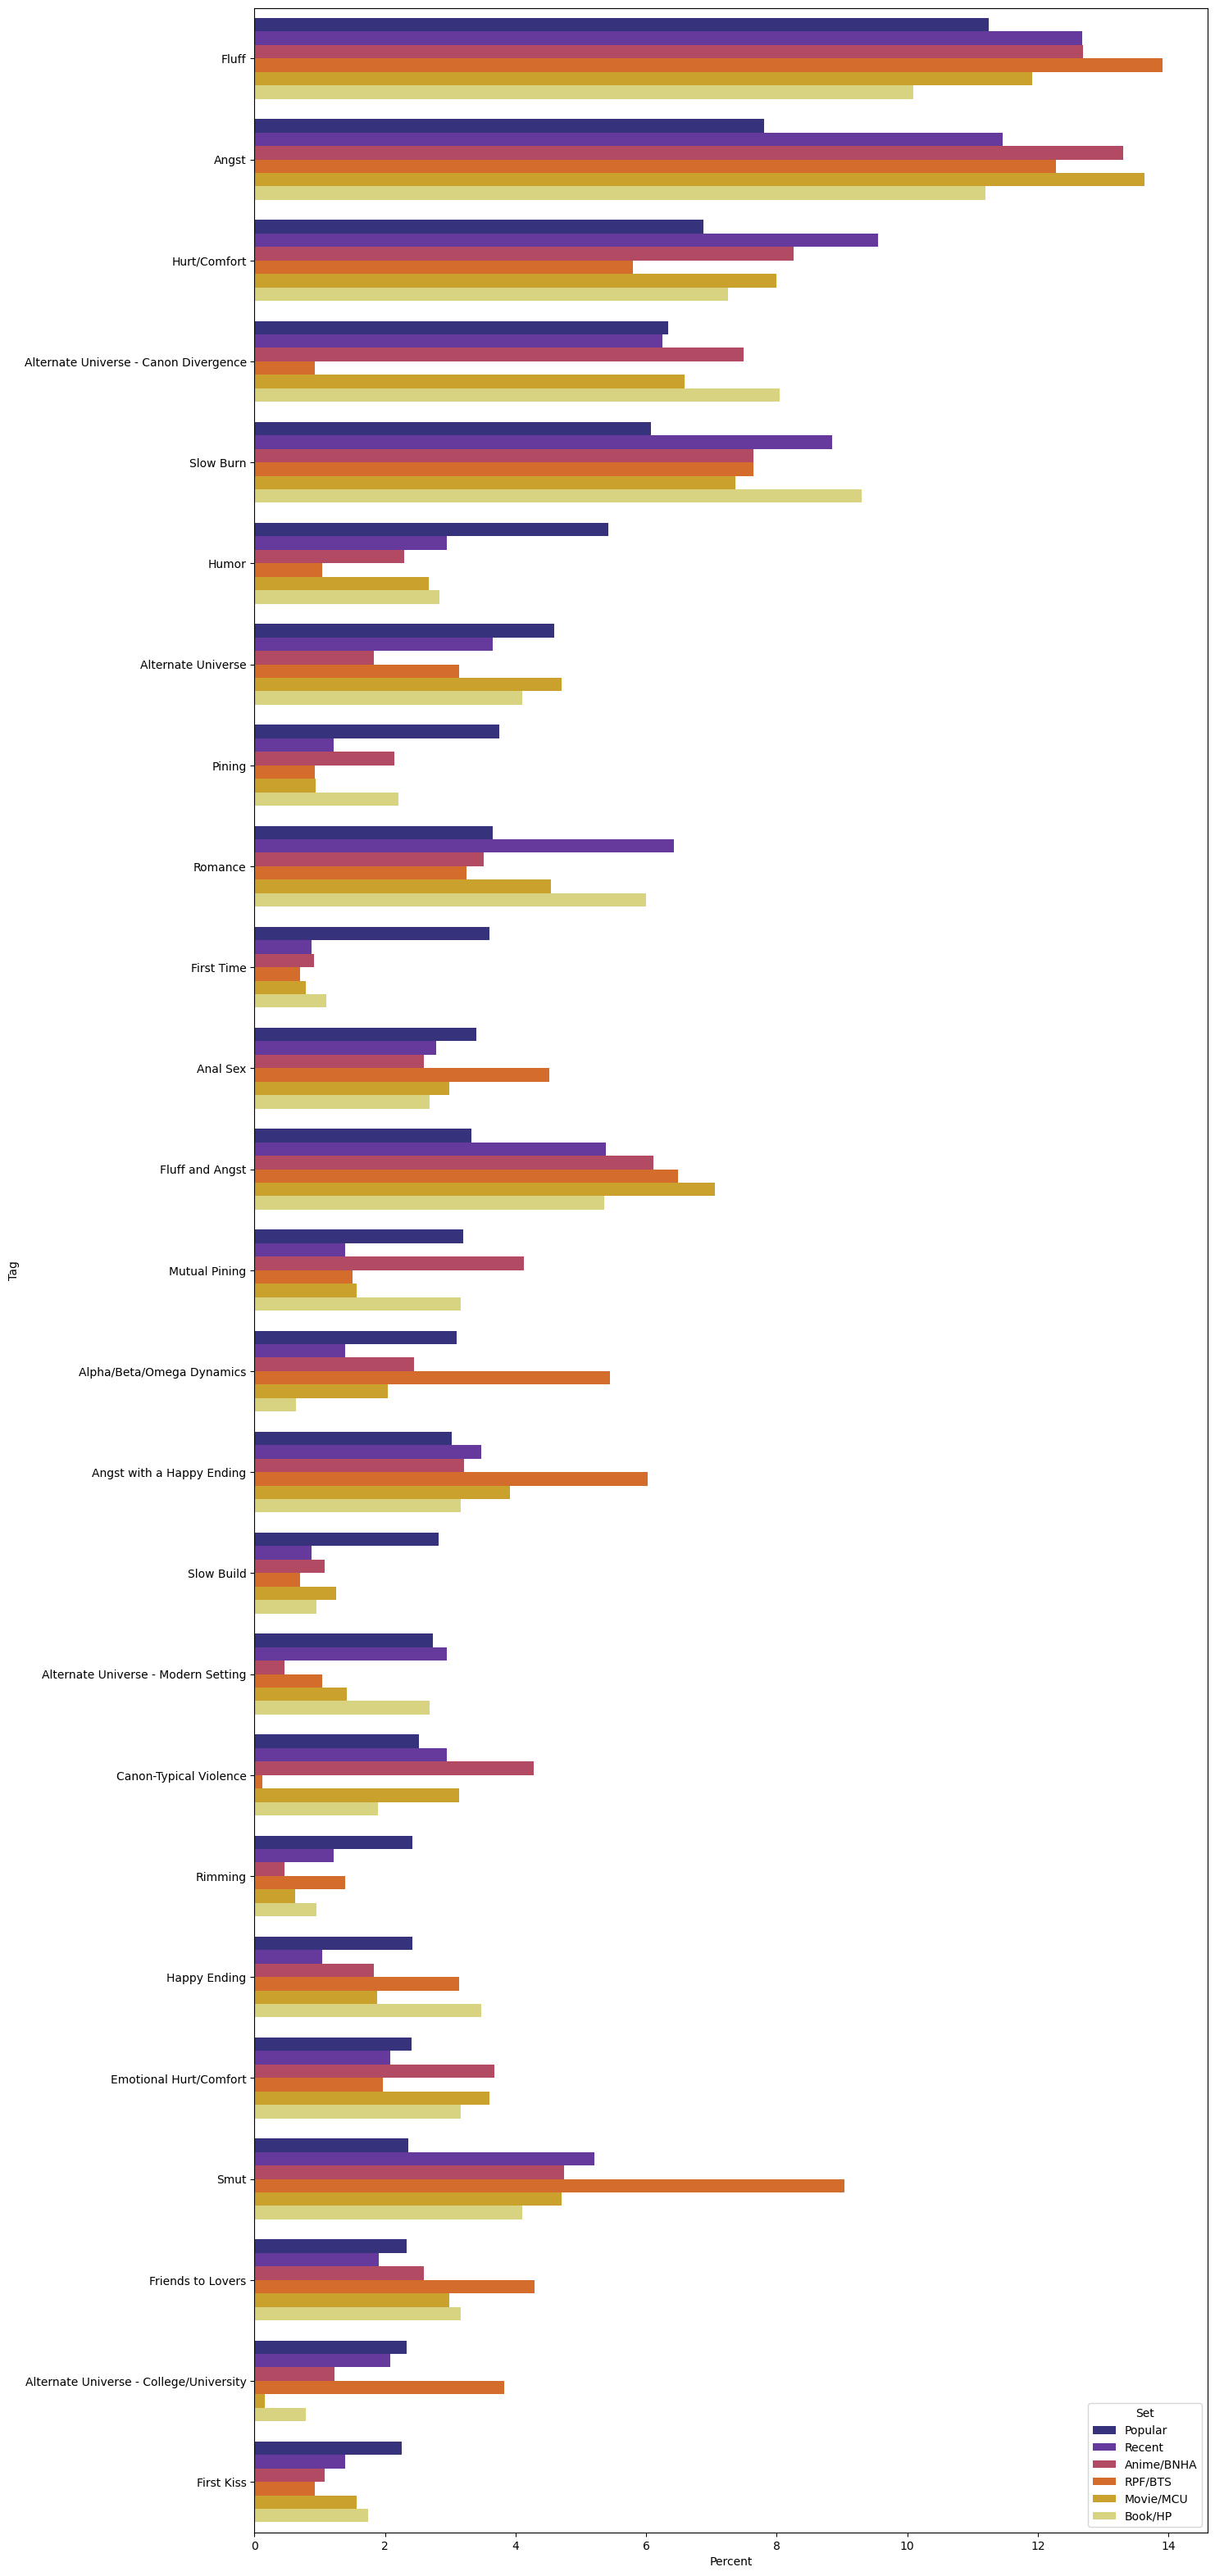

In [143]:
plt.figure(figsize=(15,40))
multi_tag_fig = sns.barplot(x = 'Percent', 
                               y = 'Tag',
                               hue = 'Set',
                               data = multi_tag_dist,
                               orient="h",
                              palette="CMRmap",)
multi_tag_fig.figure.savefig('multi_tag_dist_fig.jpg')

This is a lot of information in one graph, I know, but there's a lot of super interesting information here. I think the most can be learned by looking at the outliers. The one that stands out the most, just looking at it, is that spike for RPF/BTS under "Smut." That's the tag for basically written porn. Our representation for "real person fic" is the most explicit, as shown in the previous rating distribution as well. In modern fan scholarship, fanfiction is often seen as the response to repression and expression of desire, so why is it so stark when the characters are real people?

### "Category" (Romantic Pairing Type) Distribution

Archive of Our Own has a very odd use of the term "category." If the above data has proven anything, it should be that romance is central to fanfiction as a genre. Ao3's use of "category" reflects that. It is used to reference the genders of the characters in romantic relationships. The categories are: F/M (female/male, heterosexual), M/M (male/male), F/F (female/female), Multi (poly relationships, genders unspecified), Gen (no romantic relationships), and Other.

Note the prevalence, just in these categories, of non-heterosexual relationships. Fanfiction is known for being queer reimaginings of popular media, but how much does that hold up?

In [144]:
category_drop = top_fics.copy()
category_drop = category_drop.dropna(subset=["category"])

In [145]:
category_string = ','.join(list(category_drop["category"].values))
cat_tokens = category_string.replace('"', '').replace(' ','').split(",")
freq_cat = Counter(cat_tokens)
cat_dist = pd.DataFrame(freq_cat.most_common(6), columns = ["Category", "Frequency"])
cat_dist["Percent"] = (cat_dist["Frequency"] / cat_dist["Frequency"].sum()) * 100
cat_dist

,Category,Frequency,Percent
0,M/M,2723,66.236925
1,Gen,602,14.643639
2,F/M,408,9.924593
3,F/F,218,5.302846
4,Multi,125,3.040623
5,Other,35,0.851374


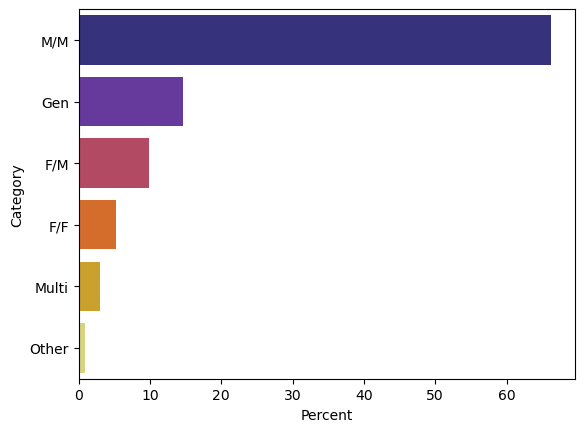

In [146]:
tags_fig = sns.barplot(x = 'Percent', 
                         y = 'Category', 
                         data = cat_dist,
                         orient="h",
                         palette="CMRmap")

Yes, we can confirm that the majority of romantic relationships in fanfiction are distinctly not straight. Noteworthy, though, is that even Gen and F/M rank *above* F/F, indicating the while this literature may not be heterosexual, it's not necessarily inclusive, either.

We're going to do that same processing on the rest of the data.

In [147]:
cat_dist["Set"] = "Popular"


#recent
recent_cat_drop = recent_fics.copy()
recent_cat_drop = recent_cat_drop.dropna(subset=["category"])

category_string = ','.join(list(recent_cat_drop["category"].values))
cat_tokens = category_string.replace('"', '').replace(' ','').split(",")
freq_cat = Counter(cat_tokens)
recent_cat_dist = pd.DataFrame(freq_cat.most_common(6), columns = ["Category", "Frequency"])
recent_cat_dist["Percent"] = (recent_cat_dist["Frequency"] / recent_cat_dist["Frequency"].sum()) * 100
recent_cat_dist["Set"] = "Recent"

#anime
bnha_cat_drop = bnha_fics.copy()
bnha_cat_drop = bnha_cat_drop.dropna(subset=["category"])

category_string = ','.join(list(bnha_cat_drop["category"].values))
cat_tokens = category_string.replace('"', '').replace(' ','').split(",")
freq_cat = Counter(cat_tokens)
bnha_cat_dist = pd.DataFrame(freq_cat.most_common(6), columns = ["Category", "Frequency"])
bnha_cat_dist["Percent"] = (bnha_cat_dist["Frequency"] / bnha_cat_dist["Frequency"].sum()) * 100
bnha_cat_dist["Set"] = "Anime/BNHA"

#rpf
bts_cat_drop = bts_fics.copy()
bts_cat_drop = bts_cat_drop.dropna(subset=["category"])

category_string = ','.join(list(bts_cat_drop["category"].values))
cat_tokens = category_string.replace('"', '').replace(' ','').split(",")
freq_cat = Counter(cat_tokens)
bts_cat_dist = pd.DataFrame(freq_cat.most_common(6), columns = ["Category", "Frequency"])
bts_cat_dist["Percent"] = (bts_cat_dist["Frequency"] / bts_cat_dist["Frequency"].sum()) * 100
bts_cat_dist["Set"] = "RPF/BTS"

#movie
mcu_cat_drop = mcu_fics.copy()
mcu_cat_drop = mcu_cat_drop.dropna(subset=["category"])

category_string = ','.join(list(mcu_cat_drop["category"].values))
cat_tokens = category_string.replace('"', '').replace(' ','').split(",")
freq_cat = Counter(cat_tokens)
mcu_cat_dist = pd.DataFrame(freq_cat.most_common(6), columns = ["Category", "Frequency"])
mcu_cat_dist["Percent"] = (mcu_cat_dist["Frequency"] / mcu_cat_dist["Frequency"].sum()) * 100
mcu_cat_dist["Set"] = "Movie/MCU"

#book
hp_cat_drop = bts_fics.copy()
hp_cat_drop = bts_cat_drop.dropna(subset=["category"])

category_string = ','.join(list(hp_cat_drop["category"].values))
cat_tokens = category_string.replace('"', '').replace(' ','').split(",")
freq_cat = Counter(cat_tokens)
hp_cat_dist = pd.DataFrame(freq_cat.most_common(6), columns = ["Category", "Frequency"])
hp_cat_dist["Percent"] = (hp_cat_dist["Frequency"] / hp_cat_dist["Frequency"].sum()) * 100
hp_cat_dist["Set"] = "Book/HP"

#concatenate
multi_cat_dist = pd.concat([cat_dist, recent_cat_dist, bnha_cat_dist, bts_cat_dist, mcu_cat_dist, hp_cat_dist])
multi_cat_dist

,Category,Frequency,Percent,Set
0,M/M,2723,66.236925,Popular
1,Gen,602,14.643639,Popular
2,F/M,408,9.924593,Popular
3,F/F,218,5.302846,Popular
4,Multi,125,3.040623,Popular
5,Other,35,0.851374,Popular
0,F/M,181,32.206406,Recent
1,M/M,173,30.782918,Recent
2,Gen,80,14.234875,Recent
3,F/F,64,11.387900,Recent


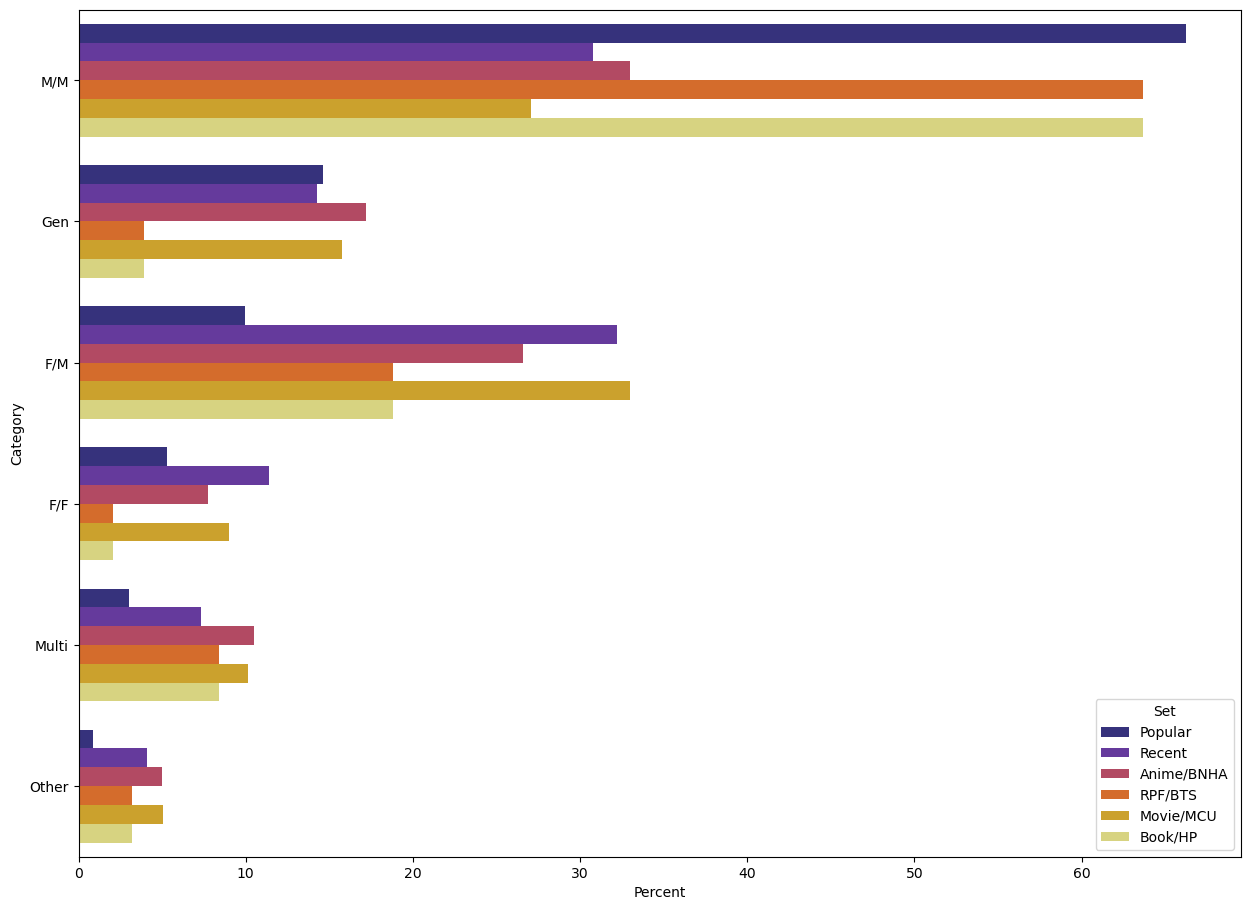

In [148]:
plt.figure(figsize=(15,11))
multi_cat_fig = sns.barplot(x = 'Percent', 
                         y = 'Category',
                         hue = 'Set',
                         data = multi_cat_dist,
                         orient="h",
                         palette="CMRmap")

Whoa! Each fandom has very different distributions here. Some of them make sense; BTS is only men, of course the romantic relationships are going to be mostly M/M. What's interesting, though, is that in popular fic, M/M is still even more predominant than it is in BTS. In the "Recent" and "MCU" cateories, F/M is even more popular than M/M. That shows that even though people are writing F/M works, people are reading and liking M/M works with more volume. I'm eager to look into each of these fandoms more to figure out why they are all so different.

# Word2Vec

I had been hoping that these models would help me show the importance of emotion and relationships within the genre of fanfiction, and it only partially did that. While not central to any of my arguments or research questions, this model is still fun to play with and shows, at the very least, how much "ships" (popular relationships in fandoms) affect how this data is viewed.

Models created using the help of [this tutorial by Kavita Ganesan](https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.YNgJ8TZuc-R).

In [149]:
fic_text = top_fics["body"]
type(fic_text[0])

str

These next steps take a really... really...... really long time to process. To run them fresh, feel free to uncomment the commented lines and comment the read_csv and Word2Vec.load lines. For ease, I've uploaded the files and model I created with them.

In [150]:
# fics_tokenized = []
# for i in range(3000):
#     words = []
#     j = gensim.parsing.preprocessing.remove_stopwords(str(fic_text[i]))
#     tokens = gensim.utils.simple_preprocess(j)
#     words = list(map(str.strip, tokens))
#     fics_tokenized.append(words)

In [151]:
# no_stops = []
# for i in range(3000):
#     print("Processing " + str(i) + "...")
#     k = [word for word in fics_tokenized[i] if word not in stopwords.words('english')]
#     no_stops.append(k)

In [152]:
no_stops = pd.read_csv("no_stops_popular_tokens.csv")

In [153]:
# no_stops_popular_df = pd.DataFrame({'col':no_stops})
# no_stops_popular_df.to_csv("no_stops_popular_tokens.csv")

In [154]:
# popular_model = gensim.models.Word2Vec(no_stops)
popular_model = gensim.models.Word2Vec.load("popular_model.model")

Now, play with it! Type in some characters and see who people most likely ship them with, it's fun :)

In [155]:
popular_model.wv.most_similar(positive="yoongi")

[('jimin', 0.9706425666809082),
 ('taehyung', 0.966130793094635),
 ('jeongguk', 0.9629248380661011),
 ('jungkook', 0.9568336606025696),
 ('namjoon', 0.9460700750350952),
 ('hoseok', 0.9406210780143738),
 ('seokjin', 0.933020293712616),
 ('tae', 0.8328649997711182),
 ('hyung', 0.8084059357643127),
 ('jaebum', 0.7760547399520874)]

In [156]:
popular_model.wv.similarity("draco", "harry")

0.9416376

In [157]:
# popular_model.save("popular_model.model")

We want to visualize this, now!

In [158]:
word_vectors = list(popular_model.wv.get_normed_vectors())

In [159]:
# if you want to see the list of vocab!
# popular_model.wv.key_to_index

In [160]:
for_pca = PCA(n_components = 2)
pca_out = for_pca.fit_transform(word_vectors)

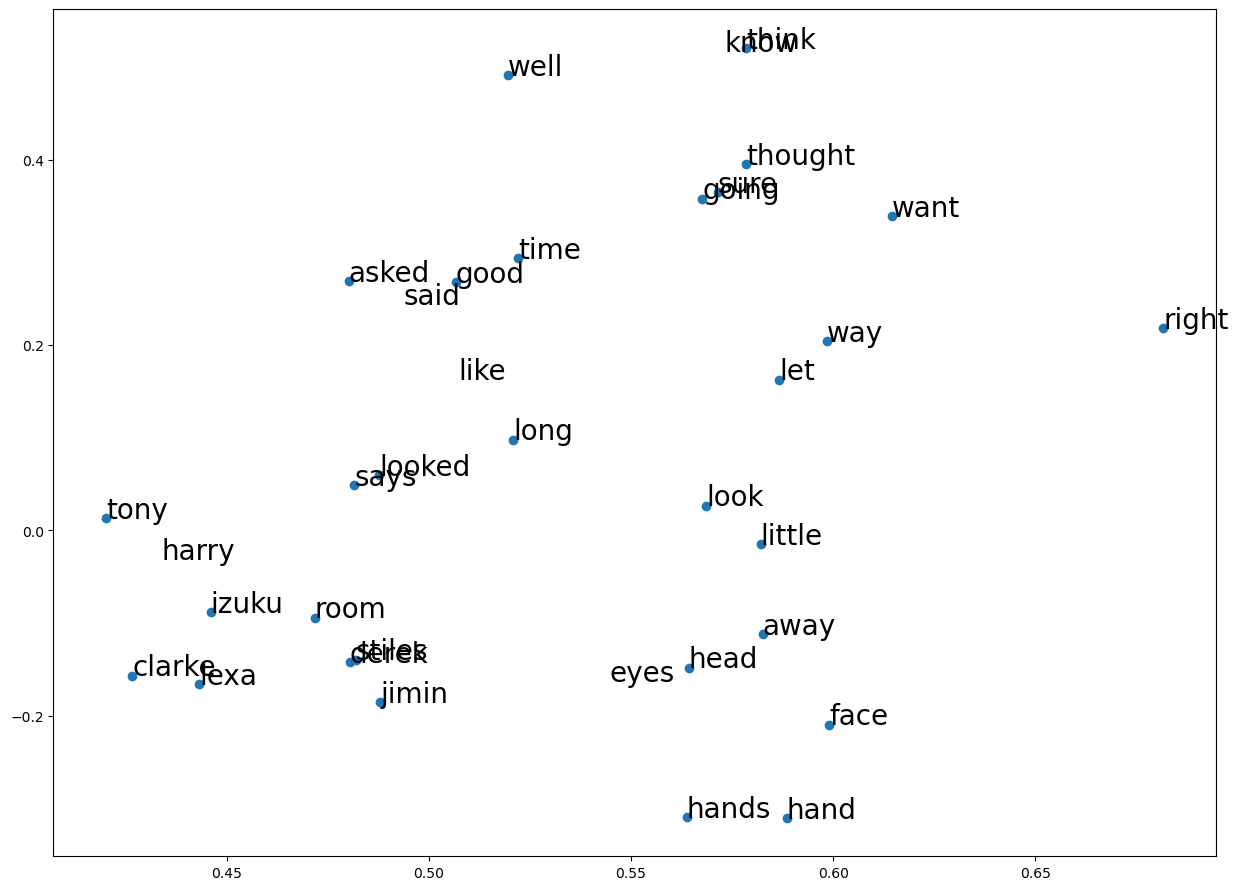

In [161]:
plt.figure(figsize = (15,11))
plt.scatter(pca_out[:, 0][5:35], pca_out[:, 1][5:35])
words = list(popular_model.wv.key_to_index)
for i, word in enumerate(words[0:35]):
    plt.annotate(word, size = 20, xy=(pca_out[i, 0], pca_out[i, 1]))
plt.show()

This doesn't honestly help me all that much, but look at the bottom left corner. Look at those two dots, right on top of each other: "stiles" and "derek." Those are the two names in an incredibly popular ship out of the *Teen Wolf* fandom; see also the proximity between "clarke" and "lexa," a ship from the show *The 100*. In this corpus, imagined romantic relationships define the word relationships as well.

# Conclusions

This is part of a much longer period of study. I have been researching and writing about non-normative literature for years, and based on extant scholarship on the subject, I expected the writings on Archive of Our Own to show very specific tropes, writing styles, ideas, and concepts.  For the most part, that was true.  All barplots are sorted in the order of most to least frequent tag within my core dataset of popular works. 

All the most popular tags are emotionally driven, with a focus on how a work may make the reader feel. "Fluff," the most popular tag, is a term fairly unique to fanfiction, and means that the writer fews the work as something light-hearted and intends to bring no negative feeling. "Angst," the second most popular, similarly describes a feeling, rather than a theme. While many of my individual fandom samples followed the same trends as the "Popular" works, in some cases, individual fandoms or my small sample of "Recent" works had stark differences. For example, in the Marvel Cinematic Universe fandom there are more works with F/M relationships than M/M, whereas in popular works, over 66% of the relationship tags are M/M. 

My initial research question on what tagging says about fanfiction, though, is that it is driven by emotions. There is no "science fiction" or "fantasy" tag, but instead "Angst," "Fluff," and "Hurt/Comfort." Fanfiction is not about themes, it is about making the reader feel a specific way.

### Further Research

That outlier spike in the lower half of Graph 1 indicates that the BTS fandom has almost twice as many works tagged "Smut" than any other fandom. In further investigation, I want to know if that trend continues across other RPF, and why this fandom is such an outlier. I also want to give the scraper more time and get bigger data sets from individual fandoms. 500 is a relatively small sample and I could get so much more information from these and other fandoms. I would also like to analyze topic models in more depth; my Word2Vec model didn't get me anything useful other than ship-based character associations but perhaps TF-IDF or Doc2Vec might.

I want to look specifically at "RPF" fandoms; my work outside of data is focused on parasocial relationships, and fandom is an incredible expression of that type of connection. The BTS fandom gave me the most interesting data, I think, and I want to use that as a jumping off point to use psychoanalytic criticism to look at how desire is shaped in a digital age.